In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats 
import statsmodels.api as sm
import statsmodels.stats.api as sms

Consider following data generating scheme:
<p>
Parameters
<li> $N$ = sample size
<li> $p$ = probability of treatment
<li> $b$ = ATE (treatment effect)
</p>

<p>$Y_{pre}$ ~ Normal(1,1)</p>
<p>$A$ ~ Bernoulli(p)</p>
<p>$Y_{post}$ ~ Normal($b$*$A$ + $y_{pre}^2$, 1)

Run a simulation based on the following generated data as above and estimate the treatment effects using:
<li> Differences in means</li>
<li> Regression controlling for y_pre</li>
<li> CUPED controlling for y_pre</li>
<li> Difference in differences</li>

Repeat 10K times and assess bias and variance

## Coding CUPED

In [35]:
def cuped_adjustment(X, Y, assignment):
    cv = np.cov(X, Y)
    theta = cv[0,1] / cv[1,1]
    X_mu = np.mean(X)
    Y_cuped = Y - (X - X_mu)*theta
    return Y_cuped

# example implementation
# https://bytepawn.com/reducing-variance-in-ab-testing-with-cuped.html

In [36]:
def p_value(A,B):
    return stats.ttest_ind(A, B)

In [110]:
data = [x for x in range(100, 10000, 100)]
p = 0.1
b = 5

df = []
for i in data:
    Y_pre = np.random.normal(1, 1, i)
    A = np.random.binomial(1, p, i)
    Y_post = A*b  + np.square(Y_pre) + np.random.normal(0,1)

    simulation = pd.DataFrame({'Y_pre':Y_pre, 'Treatment':A, 'Y_post':Y_post})

    treatment = simulation[simulation['Treatment'] == 1]
    control = simulation[simulation['Treatment'] == 0]

    t_mu = treatment['Y_post'].mean()
    c_mu = control['Y_post'].mean()
#     print("for N = {}".format(i))



#     print("difference in means:")
    mu_diff = t_mu - c_mu
    mean_diff_cm = sms.CompareMeans(sms.DescrStatsW(treatment['Y_post'].values), 
                                    sms.DescrStatsW(control['Y_post'].values))
    mean_diff_conf = mean_diff_cm.tconfint_diff(usevar='unequal')
    diff_means = {'method': 'diff_in_means',
                       'N': i,
                       'observed_treatment_effect':mu_diff,
                       'conf_int':mean_diff_conf}       
    
#     print(mu_diff)
#     print(mean_diff_conf)
#     print()
    
    
    alpha = 0.05
    X = simulation.iloc[:, :2].values
    Y = simulation['Y_post'].values

    model_lr = sm.OLS(Y, sm.add_constant(X)).fit()
    conf_interval = model_lr.conf_int(alpha)
    b_conf_int = conf_interval[-1]
    

    #check that coef of our treatment effect, should return  b
#     b_hat = model.coef_[1]
    print("regression controlled treatment effect")
#     print(model_lr.summary())
    print(model_lr.params[-1])
    print(b_conf_int)
    regression_data = {'method': 'regression',
                       'N': i,
                       'observed_treatment_effect':model_lr.params[-1],
                       'conf_int':tuple(b_conf_int)}    
    
    print()

    print("CUPED Adjusted Mean")
    Y_cuped = cuped_adjustment(X[:, 0],Y,A)
#     X is covariates, Y is outcome, A = assignment
    Y_t_cuped = Y_cuped[np.where(A==1)]
    Y_c_cuped = Y_cuped[np.where(A==0)]
    
    t_cuped_mu = np.mean(Y_t_cuped)
    c_cuped_mu = np.mean(Y_c_cuped)
    diff_cuped = t_cuped_mu - c_cuped_mu
    cm = sms.CompareMeans(sms.DescrStatsW(Y_t_cuped), sms.DescrStatsW(Y_c_cuped))
    cuped_conf = cm.tconfint_diff(usevar='unequal')
    print(cm.tconfint_diff(usevar='unequal'))
#     pval = p_value(Y_t_cuped, Y_c_cuped)
    print(diff_cuped)
#     print(pval)
#     print(cm)
    print()
#     build dataframe
    cuped_data = {'method': 'cuped',
                  'N': i,
                  'observed_treatment_effect':diff_cuped,
                  'conf_int':cuped_conf}
    
    df.append(diff_means)
    df.append(regression_data)
    df.append(cuped_data)
                                                   
                                                   
    

regression controlled treatment effect
5.1564223768041115
[4.15177677 6.16106799]

CUPED Adjusted Mean
(2.6396776876300114, 4.2605056782934385)
3.4500916829617267

regression controlled treatment effect
5.113367746637841
[4.55728533 5.66945016]

CUPED Adjusted Mean
(4.074328983428516, 6.085413304711028)
5.079871144069772

regression controlled treatment effect
5.206008516545856
[4.72716223 5.6848548 ]

CUPED Adjusted Mean
(4.3595808053272584, 5.877274754317725)
5.1184277798224915

regression controlled treatment effect
5.175543809542891
[4.77560305 5.57548457]

CUPED Adjusted Mean
(4.231262216851128, 5.642023249508258)
4.936642733179692

regression controlled treatment effect
4.60949736534171
[4.20745371 5.01154102]

CUPED Adjusted Mean
(4.118138071577923, 5.00793281986027)
4.5630354457190965

regression controlled treatment effect
5.053420798395178
[4.5244223 5.5824193]

CUPED Adjusted Mean
(4.369078817397601, 5.9418316640234154)
5.155455240710509

regression controlled treatment effe

regression controlled treatment effect
4.985248252548549
[4.85876623 5.11173027]

CUPED Adjusted Mean
(4.842013037027492, 5.232583705689763)
5.037298371358627

regression controlled treatment effect
5.058290111661446
[4.93036916 5.18621106]

CUPED Adjusted Mean
(4.846300590157526, 5.283545919877515)
5.064923255017522

regression controlled treatment effect
4.9384579618587185
[4.81318015 5.06373578]

CUPED Adjusted Mean
(4.784205081049575, 5.147986217550353)
4.966095649299963

regression controlled treatment effect
5.013159917701642
[4.88869579 5.13762404]

CUPED Adjusted Mean
(4.802646086851912, 5.190831450840854)
4.996738768846383

regression controlled treatment effect
5.046043591832896
[4.92281289 5.1692743 ]

CUPED Adjusted Mean
(4.797286822183908, 5.195753483575713)
4.99652015287981

regression controlled treatment effect
4.994492148683647
[4.87225587 5.11672843]

CUPED Adjusted Mean
(4.890538501866026, 5.2842858935162935)
5.087412197691161

regression controlled treatment effect


In [111]:
mydata = pd.DataFrame.from_dict(df)

In [112]:
mydata['conf_low'] = mydata['conf_int'].apply(lambda x: x[0])
mydata['conf_high'] = mydata['conf_int'].apply(lambda x: x[1])

In [113]:
import matplotlib.pyplot as plt

In [114]:
mydata['method'].unique()

array(['diff_in_means', 'regression', 'cuped'], dtype=object)

In [115]:
mydata['conf_width'] = mydata['conf_high'] - mydata['conf_low'] 

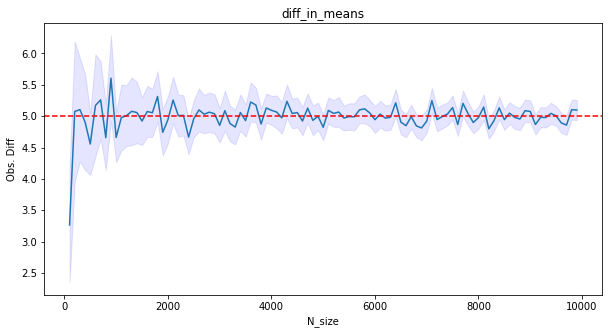

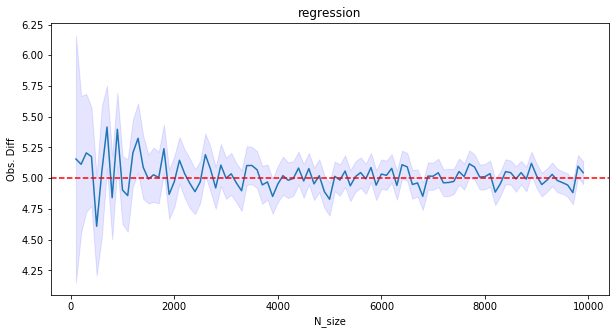

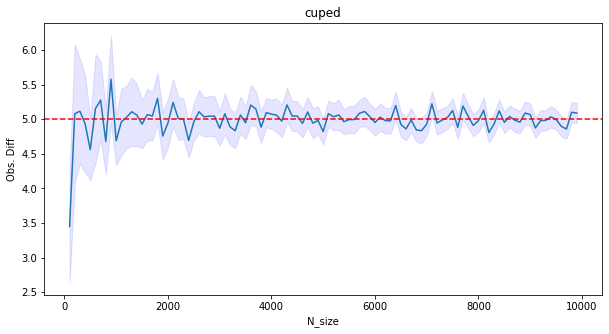

In [116]:
for m in mydata['method'].unique():

    fig, ax = plt.subplots(figsize=(10,5))

    x = mydata[mydata['method'] == m]['N'].values
    y = mydata[mydata['method'] == m]['observed_treatment_effect'].values
    ci_low = mydata[mydata['method'] == m]['conf_low'].values
    ci_high = mydata[mydata['method'] == m]['conf_high'].values
    
    ax.plot(x,y)
    plt.axhline(y=5, color='r', linestyle='--')
    ax.fill_between(x, (ci_low), (ci_high), color='b', alpha=.1)
    ax.set_title(m)
    ax.set_xlabel('N_size')
    ax.set_ylabel('Obs. Diff')


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

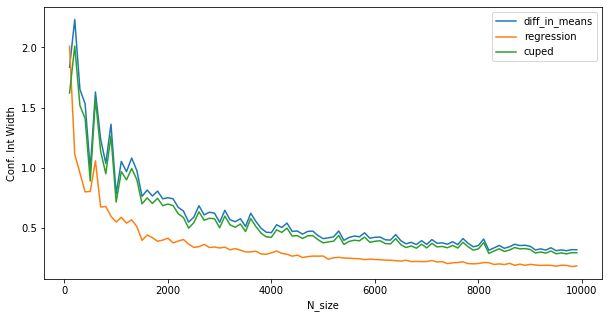

In [117]:
fig, ax = plt.subplots(figsize=(10,5))

for m in mydata['method'].unique():

    x = mydata[mydata['method'] == m]['N'].values
    y = mydata[mydata['method'] == m]['conf_width'].values
    
    ax.plot(x,y, label = m)
# ax.set_title(m)s
ax.set_xlabel('N_size')
ax.set_ylabel('Conf. Int Width')
ax.legend()


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')